In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os

In [2]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [13]:
dir = '../data_vectors/cosmodc2/2022/june6/'

#dir = '../data_vectors/cosmodc2/2022/feb11/'
file = 'twopoint_data_real.sacc' 
d = sacc.Sacc.load_fits(dir+file)

file = 'twopoint_theory_real.sacc'
t = sacc.Sacc.load_fits(dir+file)

gammax = sacc.Sacc.load_fits(dir+'twopoint_gamma_x.sacc')

file = 'summary_statistics_real.sacc'
t_cov = sacc.Sacc.load_fits(dir+file)

make_directory(dir + 'plots/')
for dt in d.get_data_types():
        print(dt)
print ('----')
for dt in t.get_data_types():
        print(dt)
print ('----') 

W = "galaxy_density_xi"
GAMMA = "galaxy_shearDensity_xi_t"
GAMMAX = "galaxy_shearDensity_xi_x"
XIP = "galaxy_shear_xi_plus"
XIM = "galaxy_shear_xi_minus"
EE = "galaxy_shear_cl_ee"
DD = "galaxy_density_cl"
ED = "galaxy_shearDensity_cl_e"

galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----
galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----


In [5]:
c = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']

# Source sample
zs = [0.19285902, 0.40831394, 0.65503818, 0.94499109, 1.2947086, 1.72779632, 2.27855242, 3. ] 
nsbins = len(zs)-1
def convert_to_z_labels(z):
    return ['$%0.2f < z < %0.2f$'%(z[i], z[i+1]) for i in range(len(z)-1)]
zs_labels = convert_to_z_labels(zs)
print(zs_labels)


# Lens sample
bias_sheth = [1.4898, 1.5476, 1.7716, 1.9811, 2.1756] # using interpolated cosmodc2 + sheth01 for the bias
bias_bhat = [1.2736598368851615, 1.3098155824414275, 1.4893638276960628, 1.668048563010521,1.8370479233940058] # using interpolated cosmodc2 + Bhattacharya11 for the bias
bias_tink = [1.404105583793727,1.4582420469437034,1.6931109537810722,1.921839383230561,2.1327663184325547] # from HOD, best guess so far
bias_2x2 = [1.445, 1.421, 1.735, 1.961, 2.213] # from 2x2pt chain from real space at fix cosmo.
zl = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
nlbins = len(zl)-1
zl_labels = convert_to_z_labels(zl)
print(zl_labels)

scale_cuts_6 = [24.75, 15.6161, 12.40438403, 12.40438403, 9.85315247] #6 Mpc/h

['$0.19 < z < 0.41$', '$0.41 < z < 0.66$', '$0.66 < z < 0.94$', '$0.94 < z < 1.29$', '$1.29 < z < 1.73$', '$1.73 < z < 2.28$', '$2.28 < z < 3.00$']
['$0.15 < z < 0.30$', '$0.30 < z < 0.45$', '$0.45 < z < 0.60$', '$0.60 < z < 0.75$', '$0.75 < z < 0.90$']


In [6]:
def get_mean(s, dt):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    for dp in dps:
        mean.append(dp.value)
        thetas.append(dp['theta'])
    mean = np.array(mean)
    return mean

def get_mean_scale_cuts_bias(s, dt, arcmin_cut, galaxy_bias):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    masks = []
    for dp in dps:
        if dt == GAMMA:
            lens_bin = int(dp.tracers[1][-1])
            mask = dp['theta'] > arcmin_cut[lens_bin]
            bias_i = galaxy_bias[lens_bin]
            if mask:
                thetas.append(dp['theta'])
                mean.append(dp.value*bias_i)
            masks.append(mask)    
        if dt == W:
            if int(dp.tracers[0][-1]) == int(dp.tracers[1][-1]):
                # auto bins
                lens_bin = int(dp.tracers[0][-1])
                 #lens_bin = int(min(int(dp.tracers[0][-1]), int(dp.tracers[1][-1])))
                mask = dp['theta'] > arcmin_cut[lens_bin]
                bias_i = galaxy_bias[lens_bin]
                #print (bias_i)
            else:
                mask = False
            if mask:
                thetas.append(dp['theta'])
                mean.append(dp.value*bias_i**2)
            masks.append(mask)    
                    
    mean = np.array(mean)
    thetas = np.array(thetas)
    masks = np.array(masks)
    return thetas, mean, masks

def get_mean_scale_cuts_nobias(s, dt, arcmin_cut):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    masks = []
    for dp in dps:
        if dt == GAMMA:
            lens_bin = int(dp.tracers[1][-1])
            mask = dp['theta'] > arcmin_cut[lens_bin]

        if dt == W:
            if int(dp.tracers[0][-1]) == int(dp.tracers[1][-1]):
                # auto bins
                lens_bin = int(dp.tracers[0][-1])
                 #lens_bin = int(min(int(dp.tracers[0][-1]), int(dp.tracers[1][-1])))
                mask = dp['theta'] > arcmin_cut[lens_bin]
            else:
                mask = False
        if mask:
            thetas.append(dp['theta'])
            mean.append(dp.value)
        masks.append(mask)    
                    
    mean = np.array(mean)
    thetas = np.array(thetas)
    masks = np.array(masks)
    return thetas, mean, masks


def get_theta(s, dt):
    dps = s.get_data_points(dt)
    thetas = []
    for dp in dps:
        thetas.append(dp['theta'])
    thetas = np.array(thetas)
    return thetas

def get_cov(s, dt):
    ind = s.indices(dt)
    cov = s.covariance.get_block(ind)
    return cov
    
def compute_chi2_gauss(data, theory, cov_th, dt, arcmin_cut = None):
    data_mean = get_mean(data, dt)
    theory_mean = get_mean(theory, dt)
    
    cov = get_cov(cov_th, dt)
    
    if arcmin_cut is None:
        invcov = np.linalg.inv(cov) 

    else:
        th = get_theta(data, dt)
        mask = th > arcmin_cut
        #print('theta', th)
        
        cov = (cov[mask]).T[mask]
        invcov = np.linalg.inv(cov)
        data_mean = data_mean[mask]
        theory_mean = theory_mean[mask]
        print('before after scale cut:', len(th), len(data_mean))
        
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


def compute_chi2_gauss_scale_cuts(data, theory, cov_th, dt, arcmin_cut = None, galaxy_bias = None):
    theta, data_mean, mask = get_mean_scale_cuts_nobias(data, dt, arcmin_cut)
    theta_th, theory_mean, mask = get_mean_scale_cuts_bias(theory, dt, arcmin_cut, galaxy_bias) # it returns a galaxy bias scaled quantity
    #print(theta, theta_th)
    assert(theta.all()==theta_th.all())
    cov = get_cov(cov_th, dt)      
    #print('before after scale cut:', len(cov[0]), len(data_mean))
    cov = (cov[mask]).T[mask]
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


def compute_chi2_jk(data, theory, dt):
    data_mean = get_mean(data, dt)
    theory_mean = get_mean(theory, dt)
    
    cov = get_cov(data, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov

def compute_chi2_jk_null(data, dt):
    data_mean = get_mean(data, dt)
    
    cov = get_cov(data, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean, invcov), data_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


## Compare theory with measurements

In [52]:
scale_cuts_6 = [24.75, 15.6161, 12.40438403, 12.40438403, 9.85315247] #6 Mpc/h
scale_cuts_6_nobins34 = [24.75, 15.6161, 110, 110, 9.85315247] #6 Mpc/h
scale_cuts_8 = [43.0, 27.0, 20.0, 16.0, 14.0] #8 Mpc/h
scale_cuts_12 = np.array(scale_cuts_6)*2
scale_cuts_16 = np.array(scale_cuts_8)*2
#scale_cuts = [64.0, 40.0, 30.0, 24.0, 21.0] #12 Mpc/h
scale_cuts_none = [0]*5 
bias = bias_tink

# get chi2s
deltachi2, ndf, cov = compute_chi2_gauss(d, t, cov_th = t_cov, dt ='galaxy_shear_xi_plus')
print('delta chi2 xip = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))


deltachi2, ndf, cov = compute_chi2_gauss(d, t, cov_th = t_cov, dt ='galaxy_shear_xi_minus')
print('delta chi2 xim = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))


deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = GAMMA, arcmin_cut = scale_cuts_none, galaxy_bias = bias)
print('delta chi2 gammat = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = GAMMA, arcmin_cut = scale_cuts_6, galaxy_bias = bias)
print('delta chi2 gammat with 6 Mpc/h scale cuts = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = W, arcmin_cut = scale_cuts_6, galaxy_bias = bias)
print('delta chi2 wtheta with 6 Mpc/h scale cuts = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))



deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = GAMMA, arcmin_cut = scale_cuts_12, galaxy_bias = bias)
print('delta chi2 gammat with 12 Mpc/h scale cuts = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = W, arcmin_cut = scale_cuts_12, galaxy_bias = bias)
print('delta chi2 wtheta with 12 Mpc/h scale cuts = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))


delta chi2 xip = 590.1/560 = 1.1
delta chi2 xim = 604.7/560 = 1.1
delta chi2 gammat = 1986.9/700 = 2.8
delta chi2 gammat with 6 Mpc/h scale cuts = 643.5/434 = 1.5
delta chi2 wtheta with 6 Mpc/h scale cuts = 146.5/62 = 2.4
delta chi2 gammat with 12 Mpc/h scale cuts = 436.9/329 = 1.3
delta chi2 wtheta with 12 Mpc/h scale cuts = 108.9/47 = 2.3


### Compare with previous set of measurements

In [12]:
# get chi2s
deltachi2, ndf, cov = compute_chi2_gauss(d, t, cov_th = t_cov, dt ='galaxy_shear_xi_plus')
print('delta chi2 xip = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))


deltachi2, ndf, cov = compute_chi2_gauss(d, t, cov_th = t_cov, dt ='galaxy_shear_xi_minus')
print('delta chi2 xim = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))


deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = GAMMA, arcmin_cut = scale_cuts_none, galaxy_bias = bias)
print('delta chi2 gammat = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = GAMMA, arcmin_cut = scale_cuts_6, galaxy_bias = bias)
print('delta chi2 gammat with 6 Mpc/h scale cuts = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss_scale_cuts(d, t, cov_th = t_cov, dt = W, arcmin_cut = scale_cuts_6, galaxy_bias = bias)
print('delta chi2 wtheta auto with 6 Mpc/h scale cuts = %0.1f/%d = %0.1f'%(deltachi2,ndf, deltachi2/ndf))




delta chi2 xip = 472.3/420 = 1.1
delta chi2 xim = 469.5/420 = 1.1
delta chi2 gammat = 1772.3/525 = 3.4
delta chi2 gammat with 6 Mpc/h scale cuts = 463.6/287 = 1.6
delta chi2 wtheta auto with 6 Mpc/h scale cuts = 95.3/41 = 2.3


# Plot measurements now

In [34]:
def plot_twopoint(s, theory=None, theory_cov = None, datatype=None, ratios = False, diff = False, diff_with_errors=False):

        
    for dt in s.get_data_types():
        
        if dt == XIP or dt == XIM:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == GAMMA :
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == W:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
        
            print(dt)
            plt.clf()
            if dt == GAMMA:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
                
            else:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    # this returns the JK cov
                    theta, xi, cov = s.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)

                    err = np.sqrt(np.diag(cov))
                    
                    if theory_cov is not None:
                        # this returns the theory cov, and overwrites the error if theory_cov is not None
                        _, _, cov = theory_cov.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        #cov = (cov[mask_ls]).T[mask_ls]
                        err = np.sqrt(np.diag(cov))
                    
                    if theory is not None:
                        theta_th, xi_th = theory.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)

                        #print ('i, j, xi_th:', i, j, xi_th)
                        if dt == GAMMA:
                            # update theory with the bias from HOD
                            xi_th_original = xi_th # save the theory without applying any bias
                            # Now update theory with the bias from HOD
                            xi_th = xi_th_original*bias_tink[j]
                            xi_th_2x2 = xi_th_original*bias_2x2[j]
                            
                        if dt == W:
                            # update theory with the bias from HOD
                            xi_th_original = xi_th # save the theory without applying any bias
                            # update theory with the bias from HOD
                            xi_th = xi_th_original*bias_tink[i]*bias_tink[j]
                            xi_th_2x2 = xi_th_original*bias_2x2[i]*bias_2x2[j]
                            
                    if ratios:
                        ax[i][j].errorbar(theta, xi/xi_th, err/xi_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement/Theory')
                    elif diff:
                        ax[i][j].errorbar(theta, xi-xi_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                        ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')
                    elif diff_with_errors:
                        q = (xi-xi_th)/err
                        #print ('xi_th already corrected:', xi_th)
                        sigma_cut = 1.
                        cut = np.abs(q)>sigma_cut
                        mask = None
                        for k in range(len(cut)):
                            if cut[len(cut)-k-1]==True and cut[len(cut)-k-2]==True and cut[len(cut)-k-3]==True:
                                mask = theta>theta[len(cut)-k-1]
                                break
                        if mask is None:
                            ax[i][j].plot(theta, q,   color = c[1], label = '(Measurement-Theory)/$\sigma$', alpha = 1.)
                            #ax[i][j].plot(theta, q,   color = c[0], label = '(Old Measurement-New Measurement)/$\sigma$(JK)', alpha = 1.)
                        else:
                            ax[i][j].plot(theta, q,   color = c[1], alpha = 0.33)
                            ax[i][j].plot(theta[mask], q[mask],   color = c[1], label = '(Measurement-Theory)/$\sigma$', alpha = 1.)
                            
                            
                        ax[i][j].fill_between(theta, -sigma_cut, sigma_cut, alpha = 0.33, color = 'powderblue')
                    else:
                        if theory is not None:
                    
                            if dt == GAMMA or dt ==W:
                                ax[i][j].plot(theta_th, xi_th_original, ls = '-', lw = '1.5', color = 'gray', label ='Theory $b=1$')
                                ax[i][j].plot(theta_th, xi_th, ls = '-', lw = '1.5', color = c[1], label = 'Theory $b_h$=Tinker10')
                                ax[i][j].plot(theta_th, xi_th_2x2, ls = '--', lw = '1.5', color = c[4], label = 'Theory $b$ from 2x2pt at fix cosmo')
                            if dt == XIP or dt == XIM:
                                ax[i][j].plot(theta_th, xi_th, ls = '-', lw = '1.5', color = c[1], label = 'Theory')

                        ax[i][j].errorbar(theta, xi, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurements')
                    if (datatype==XIP) or (datatype==XIM) or ((datatype==W or datatype==GAMMA) and j>0 or i>0):
                        ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                      verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(2, 270)
                    if datatype==W or datatype==GAMMA:
                        ax[i][j].axvspan(2, scale_cuts_6[j], color='lightgrey', alpha = 0.3)

                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')

                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==XIP:
                            ax[i][j].set_ylim(4*10**(-7), 3.5*10**(-4))
                        if datatype==XIM:
                            ax[i][j].set_ylim(2*10**(-7), 3.5*10**(-4))  
                        if datatype==GAMMA:
                            ax[i][j].set_ylim(5*10**(-6), 4.*10**(-3))  
                        if datatype==W:
                            ax[i][j].set_ylim(10**(-5), 1)  


                    if i==nsbins-1: 
                        ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
                    if j==0:
                        if datatype==XIP:
                            ax[i][j].set_ylabel(r'$\xi_+$')
                        if datatype==XIM:
                            ax[i][j].set_ylabel(r'$\xi_-$')
                        if datatype==GAMMA:
                            ax[i][j].set_ylabel(r'$\gamma_t$')
                        if datatype==W:
                            ax[i][j].set_ylabel(r'$w(\theta)$')
                            
                    if datatype!=GAMMA:
                        if i<j:
                            fig.delaxes(ax[i, j])

    ax[0][0].legend(frameon = False, loc = 'best')

    return fig


galaxy_density_xi


<Figure size 432x288 with 0 Axes>

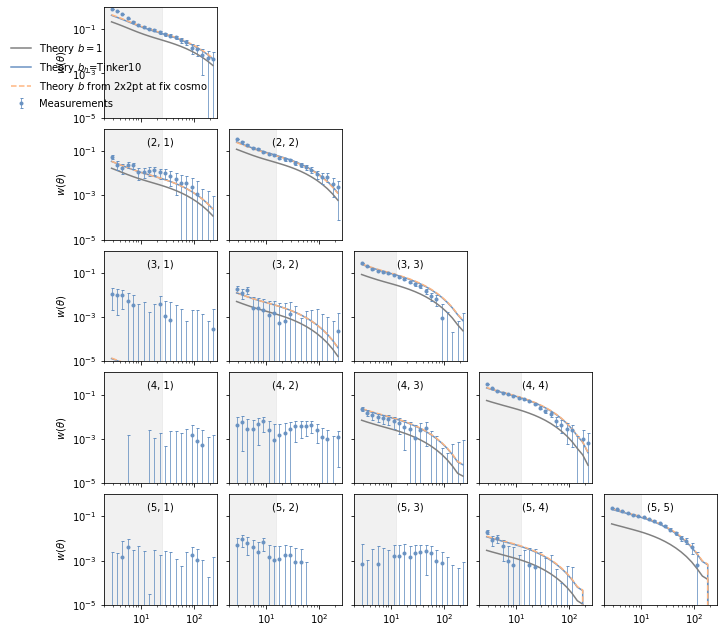

In [35]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov, datatype=W, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'wtheta.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
#plt.savefig(dir + 'plots/' + 'wtheta.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_xi


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3371: RuntimeWarning: invalid value encountered in double_scalars
  high = [v + e for v, e in zip(data, b)]


<Figure size 432x288 with 0 Axes>

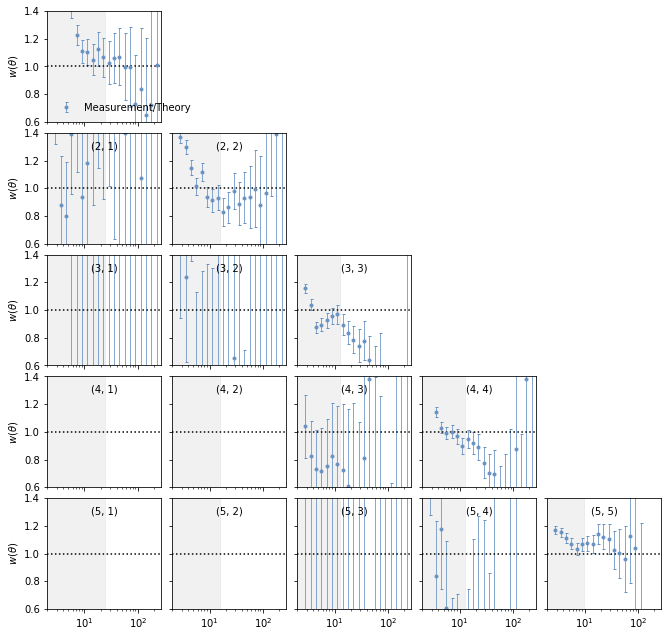

In [19]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov, datatype=W, ratios = True, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'wtheta_ratios.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'wtheta_ratios.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_xi_t


<Figure size 432x288 with 0 Axes>

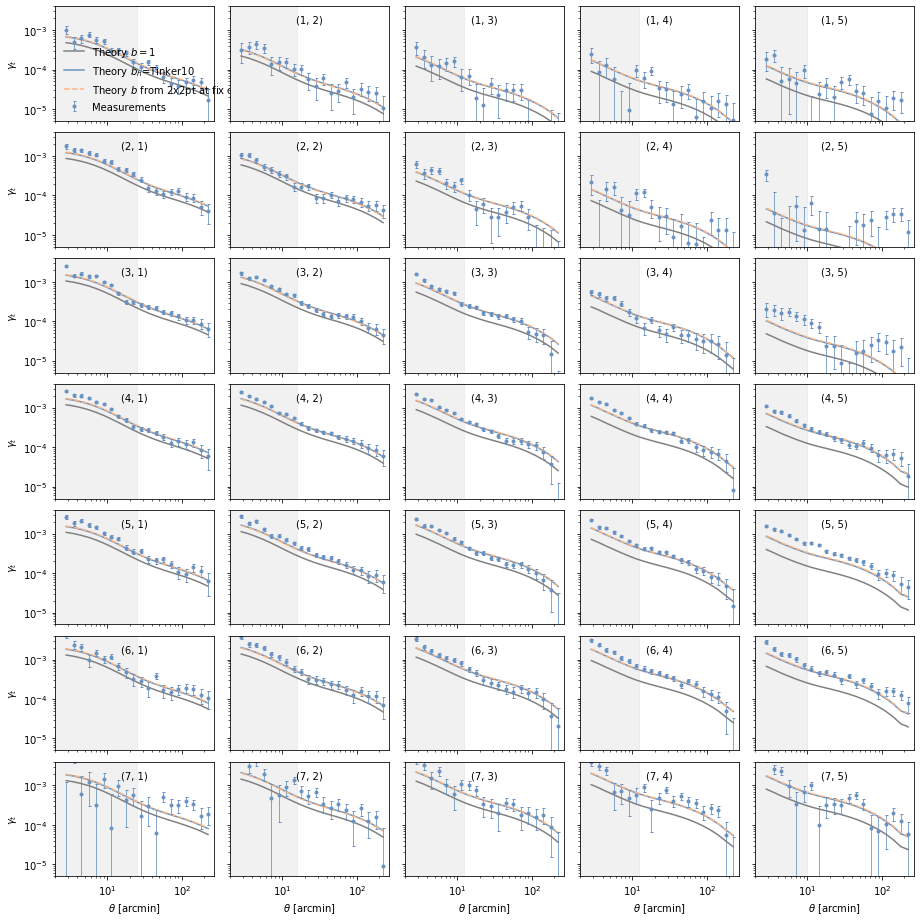

In [20]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov, datatype=GAMMA, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'gammat.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'gammat.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_xi_t


<Figure size 432x288 with 0 Axes>

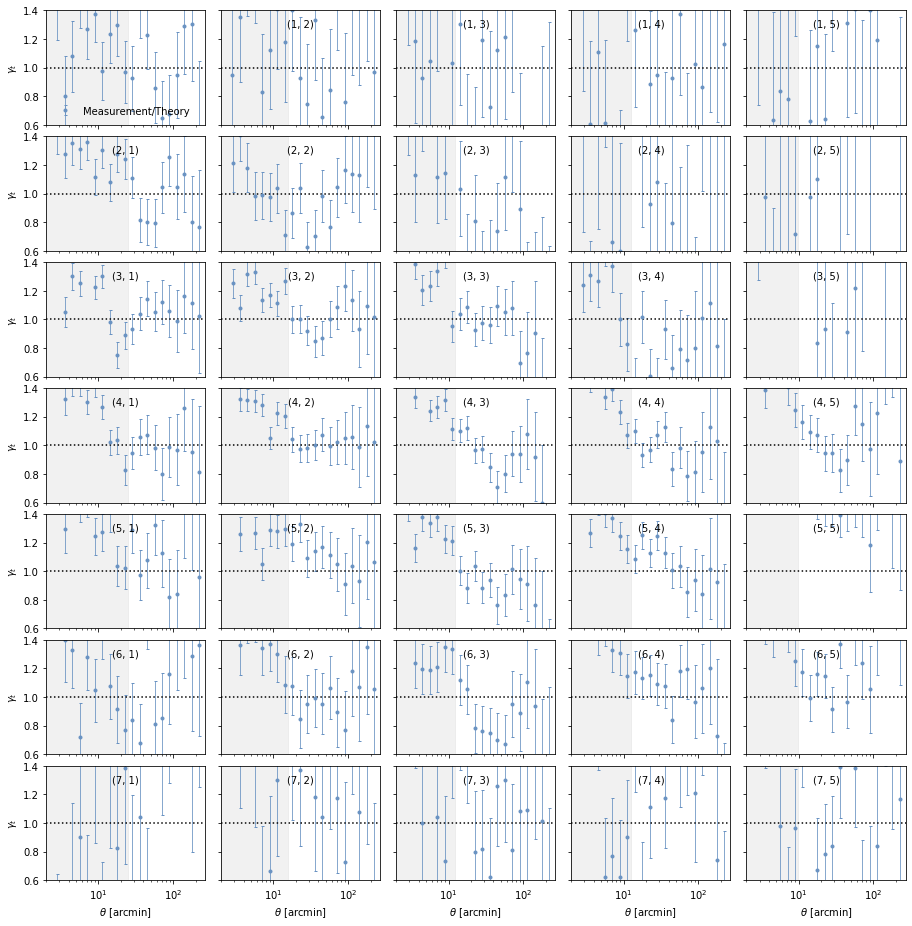

In [21]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov, datatype=GAMMA, ratios = True, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'gammat_ratios.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'gammat_ratios.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_plus


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

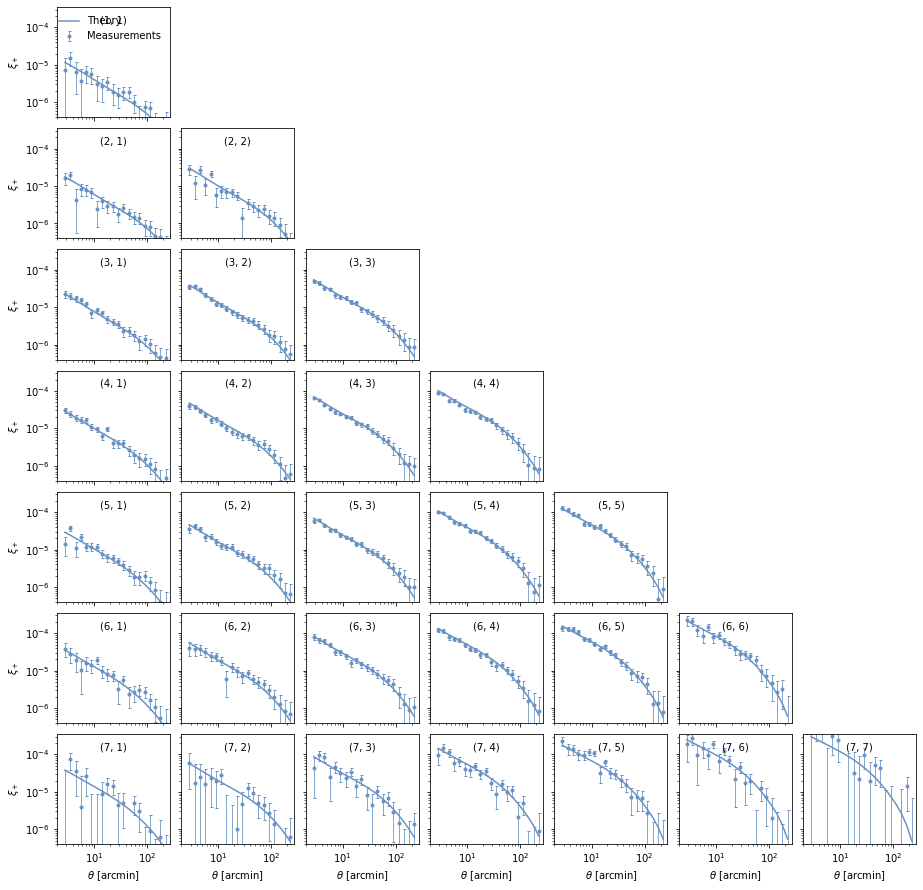

In [22]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov, datatype=XIP, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'xip.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'xip.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_minus


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

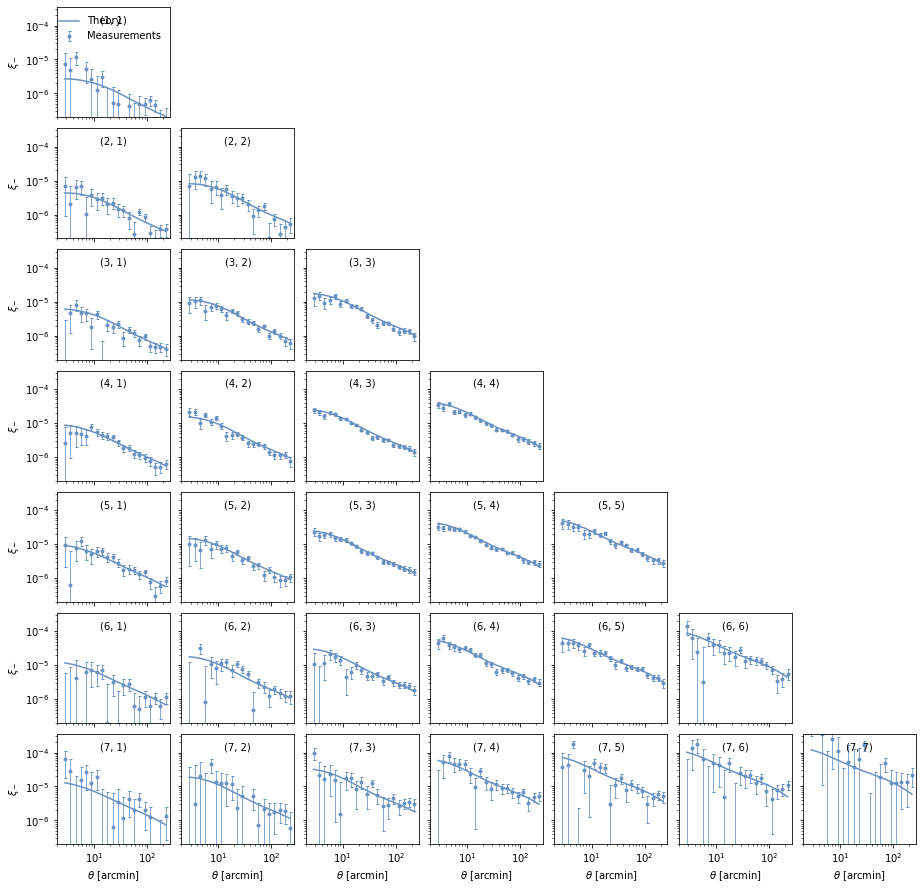

In [23]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov, datatype=XIM, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'xim.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'xim.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

# Comparing errorbars now

In [27]:
def plot_errorbars(s, theory=None, theory_cov = None, datatype=None, ratios = False):
      
    for dt in s.get_data_types():
        
        if dt == XIP or dt == XIM:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == GAMMA:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == W:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            if dt == GAMMA:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
            else:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):
                    
                    theta, xi, cov = s.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                    err = np.sqrt(np.diag(cov)) #JK error
                    
                    if theory_cov is not None:
                        _, _, cov_th = theory_cov.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err_th = np.sqrt(np.diag(cov_th))

                    if ratios:
                        ax[i][j].plot(theta, err/err_th, lw = 2, color = c[0], label = 'Jackknife/Theory')
                    
                    else:
                        ax[i][j].plot(theta, err, lw = 2, color = c[0], label = 'Jackknife')
                        ax[i][j].plot(theta, err_th, lw = 2,color = c[2],  label = 'Theory')
                        
                    ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(2, 110)
                    if datatype==W or datatype==GAMMA:
                        ax[i][j].axvspan(2, scale_cuts_6[j], color='lightgray', alpha = 0.3)
                    
                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==XIP:
                            ax[i][j].set_ylim(10**(-7), 5*10**(-4))
                        if datatype==XIM:
                            ax[i][j].set_ylim(10**(-7), 3.5*10**(-4))  
                        if datatype==GAMMA:
                            ax[i][j].set_ylim(7*10**(-6), 4.*10**(-3))  
                        if datatype==W:
                            ax[i][j].set_ylim(10**(-3), 1.2)  


                    if i==nsbins-1: 
                        ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
                    if j==0:
                        if datatype==XIP:
                            ax[i][j].set_ylabel(r'$\xi_+$')
                        if datatype==XIM:
                            ax[i][j].set_ylabel(r'$\xi_-$')
                        if datatype==GAMMA:
                            ax[i][j].set_ylabel(r'$\gamma_t$')
                        if datatype==W:
                            ax[i][j].set_ylabel(r'$w(\theta)$')
                            
                    if datatype!=GAMMA:
                        if i<j:
                            fig.delaxes(ax[i, j])

    ax[0][0].legend(frameon = False, loc = 'lower left')

    return fig


### Compare errorbars with previous sacc file

galaxy_shear_xi_plus


<Figure size 432x288 with 0 Axes>

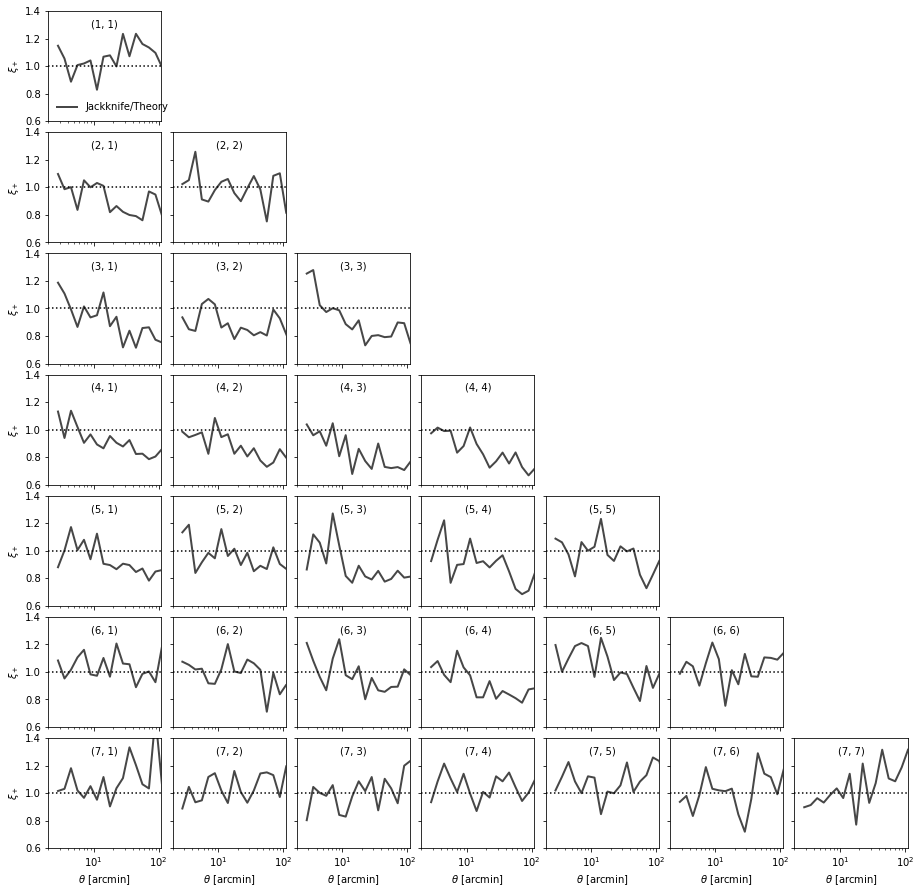

In [30]:
fig = plot_errorbars(d, theory_cov = t_cov, datatype=XIP, ratios = True)
plt.savefig(dir + 'plots/' + 'xip_errors.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_minus


<Figure size 432x288 with 0 Axes>

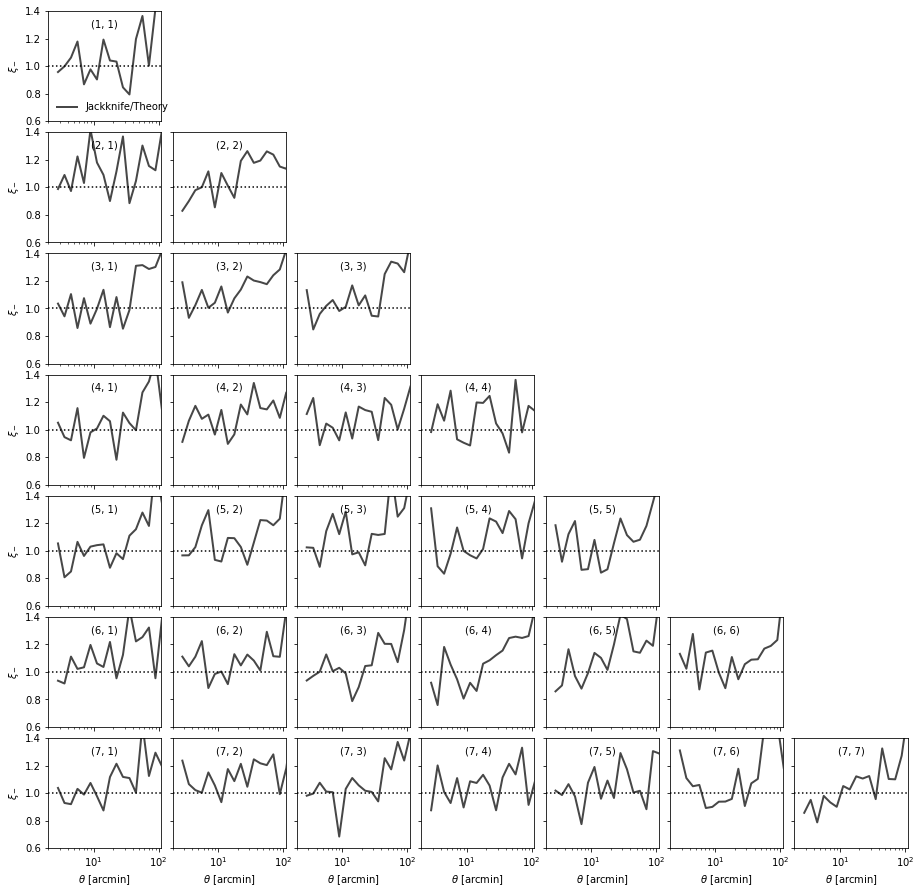

In [31]:
fig = plot_errorbars(d, theory_cov = t_cov, datatype=XIM, ratios = True)
plt.savefig(dir + 'plots/' + 'xim_errors.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_xi_t


<Figure size 432x288 with 0 Axes>

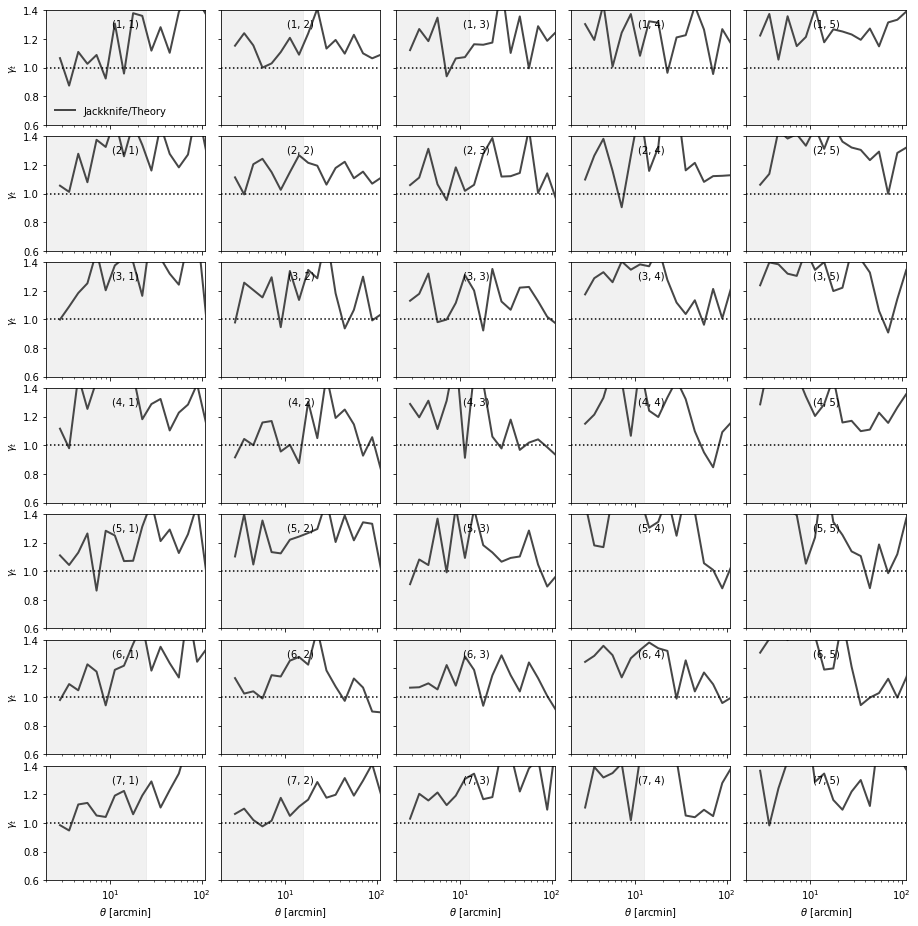

In [32]:
fig = plot_errorbars(d, theory_cov = t_cov, datatype=GAMMA, ratios = True)
plt.savefig(dir + 'plots/' + 'gammat_errors.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_xi


<Figure size 432x288 with 0 Axes>

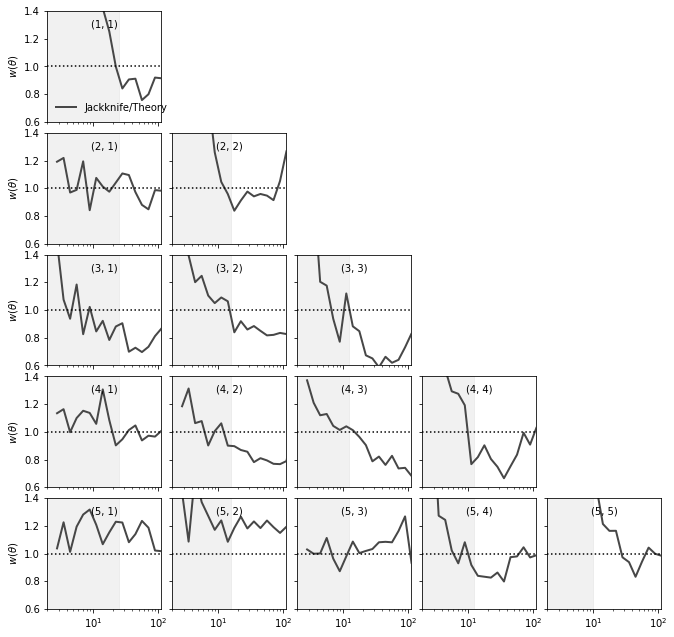

In [33]:
fig = plot_errorbars(d, theory_cov = t_cov, datatype=W, ratios = True)
plt.savefig(dir + 'plots/' + 'wtheta_errors.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

# Some cross-checks: gammax

In [36]:
def plot_gammax(s):        
    
    nbins1 = nsbins
    nbins2 = nlbins
    name1 = 'source'
    name2 = 'lens'


    fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i in range(nbins1):
        for j in range(nbins2):

            # this returns the JK cov
            theta, xi, cov = s.get_theta_xi('galaxy_shearDensity_xi_x','%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
            #print('i, j, xi:', i, j, xi)
            err = np.sqrt(np.diag(cov))
                    
            ax[i][j].errorbar(theta, xi*theta, err*theta, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[0], label = 'Measurements')
            ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                            verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlim(2, 270)
            ax[i][j].set_ylim(-0.005, 0.005)
            ax[i][j].axhline(y=0, color = 'k', ls = ':')      



            if i==nsbins-1: 
                ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
            if j==0:
                ax[i][j].set_ylabel(r'$\gamma_\times \times \theta$')

    ax[0][0].legend(frameon = False, loc = 'best')

    return fig


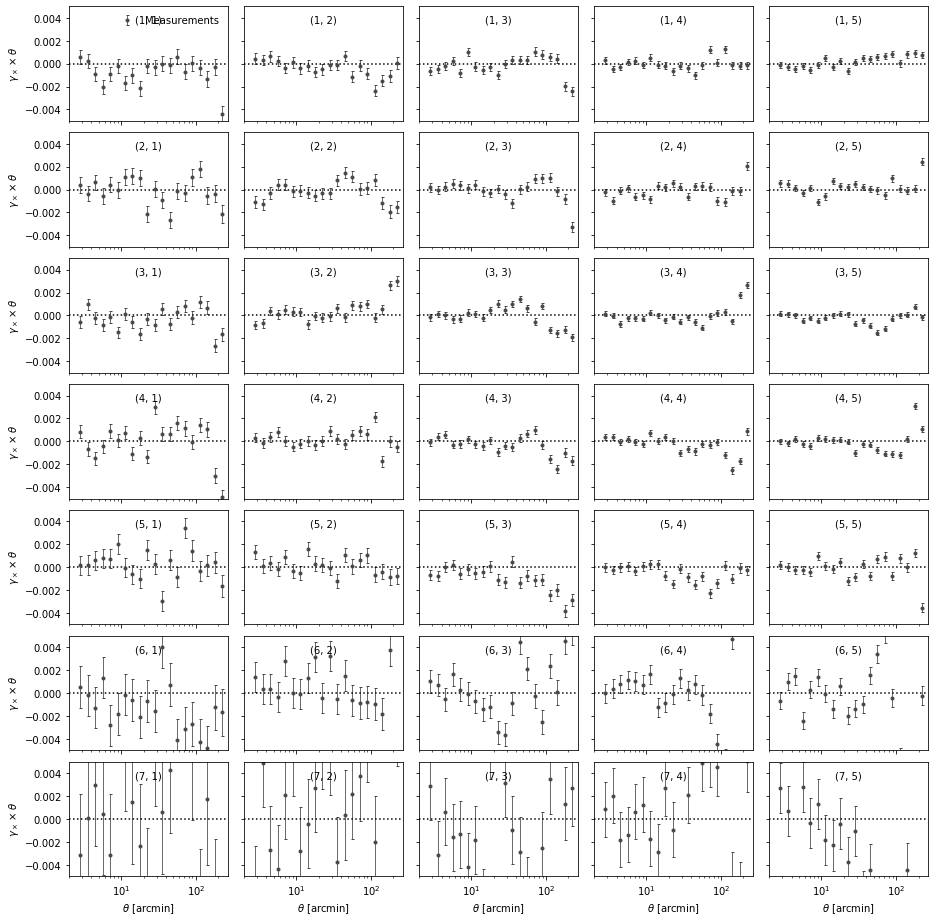

In [37]:
covname = 'JK'
fig = plot_gammax(gammax)
plt.savefig(dir + 'plots/' + 'gammax_%s'%covname, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

# Plot covariances now

In [38]:
def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

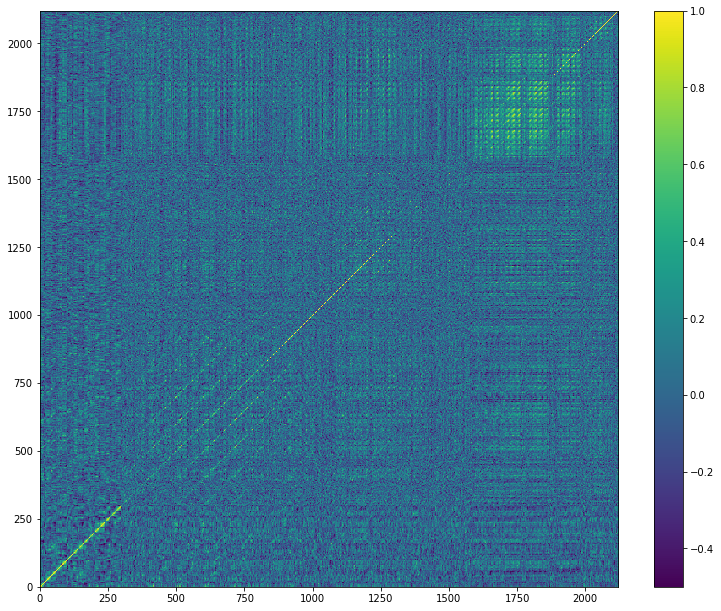

In [39]:
cov = plot_cov(d.covariance.covmat, 200)
plt.savefig(dir + 'plots/cov_3x2pt_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

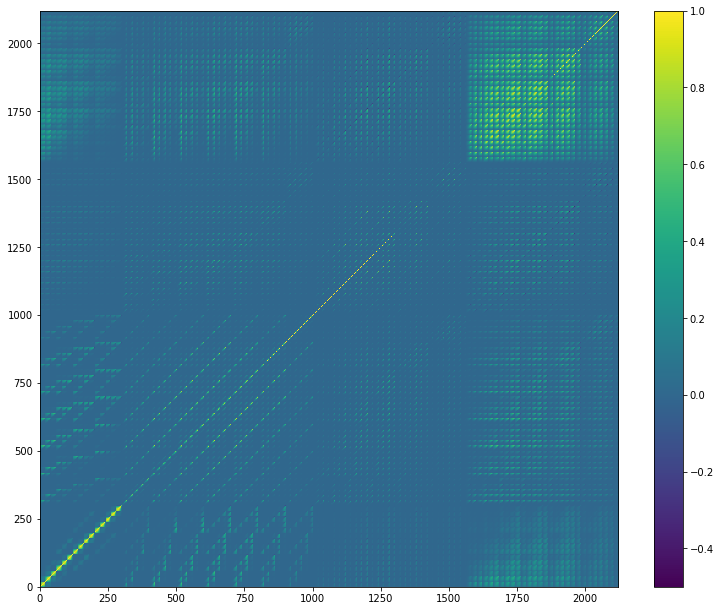

In [40]:
cov = plot_cov(t_cov.covariance.covmat, 200)
plt.savefig(dir + 'plots/cov_3x2pt_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

In [41]:
d.covariance.covmat.shape

(2120, 2120)

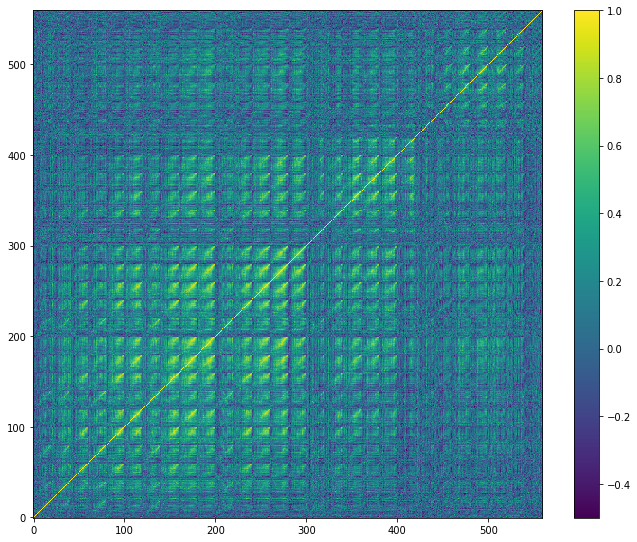

In [42]:
indices_p = d.indices('galaxy_shear_xi_plus')
cov = plot_cov(d.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xip_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

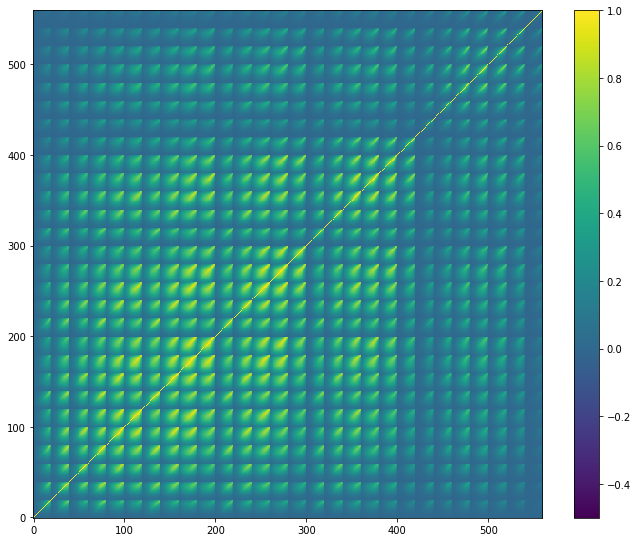

In [43]:
indices_p = t_cov.indices('galaxy_shear_xi_plus')
cov = plot_cov(t_cov.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xip_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

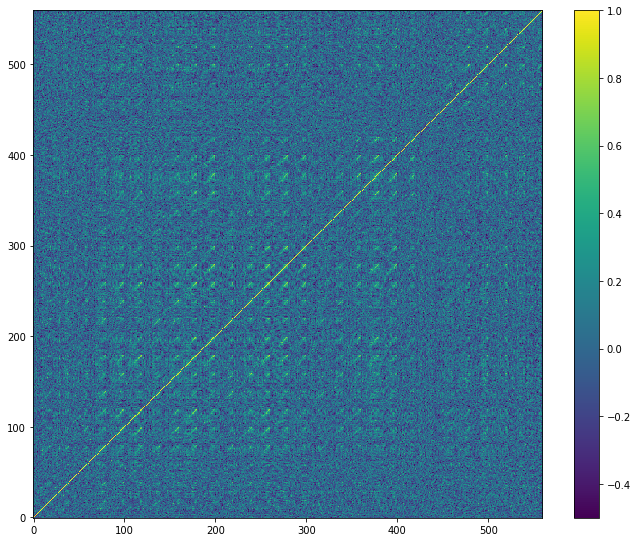

In [44]:
indices_p = d.indices('galaxy_shear_xi_minus')
cov = plot_cov(d.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xim_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

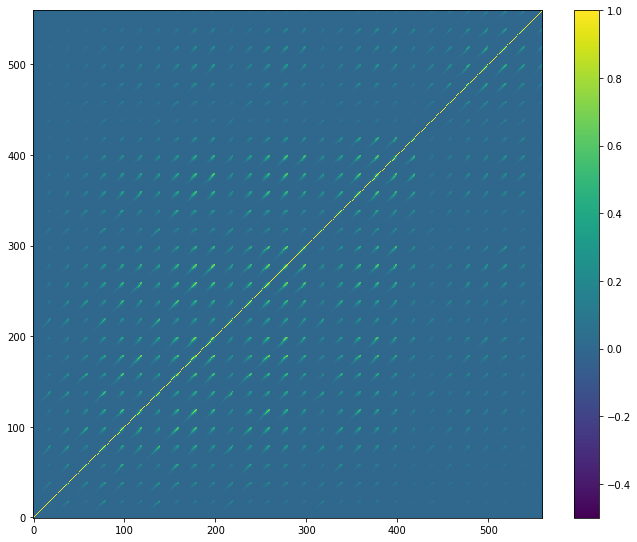

In [45]:
indices_p = t_cov.indices('galaxy_shear_xi_minus')
cov = plot_cov(t_cov.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xim_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

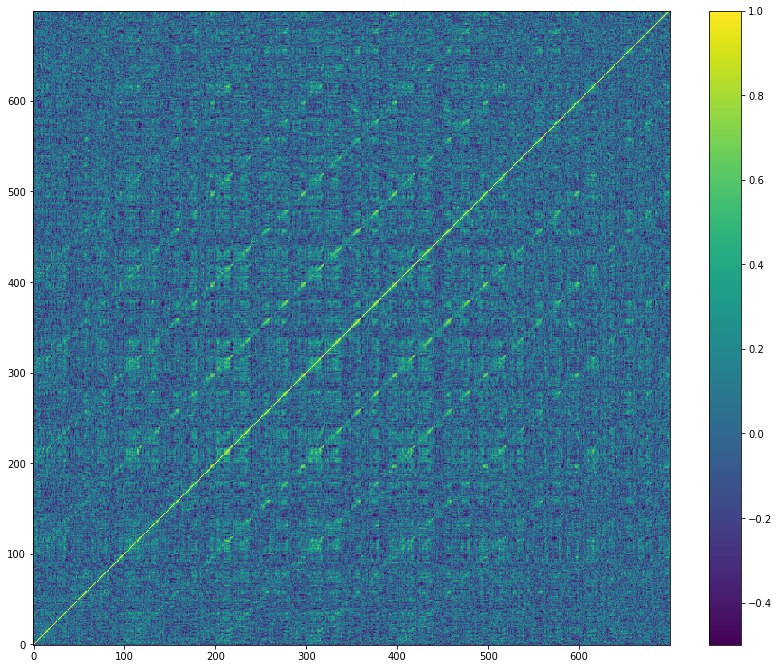

In [46]:
indices = d.indices(GAMMA)
cov = plot_cov(d.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_gt_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

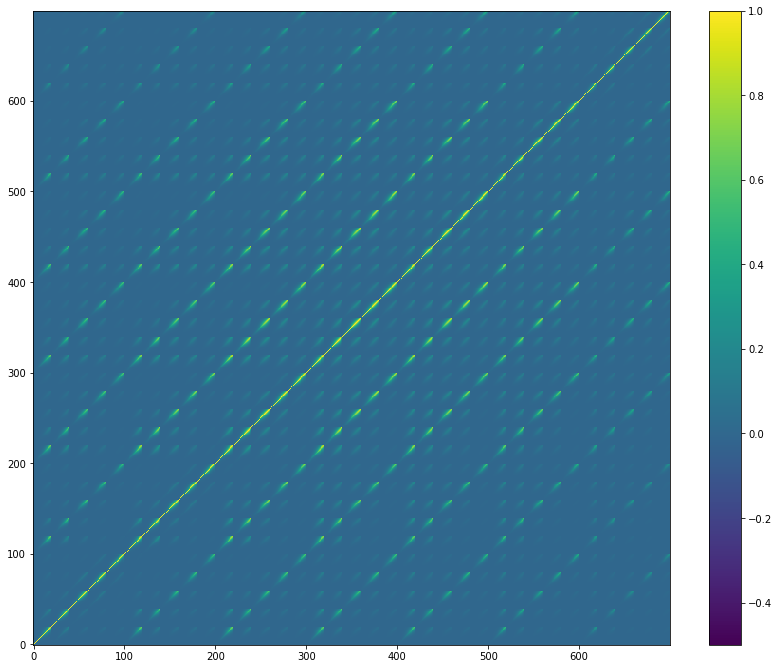

In [47]:
indices = t_cov.indices(GAMMA)
cov = plot_cov(t_cov.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_gt_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

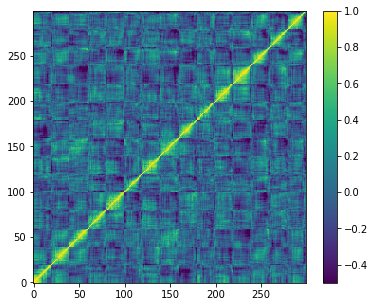

In [48]:
indices = d.indices(W)
cov = plot_cov(d.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_w_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

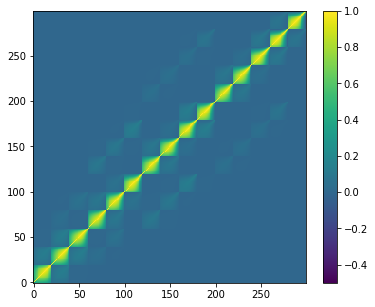

In [49]:
indices = t_cov.indices(W)
cov = plot_cov(t_cov.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_w_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)